In [1]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)

import numpy as np
import pandas as pd
import os.path
from datetime import datetime, timedelta

one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None

df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)

df.loc["OCUL"]


Drug     Stage  \
OCUL                  DEXTENZA  Allergic conjunctivitis   Phase 3   
OCUL  DEXTENZA  Ocular inflammation and pain followi...  Approved   
OCUL  DEXTENZA  Ocular inflammation and pain followi...  Approved   
OCUL  DEXTENZA  Ocular inflammation and pain followi...  Approved   

                                               Catalyst        Date  
OCUL    Phase 3 trial did not meet primary endpoint ...  06/06/2016  
OCUL    CRL July 25 2016 - due to manufacturing defi...  07/25/2016  
OCUL    CRL July 25 2016 - due to manufacturing defi...  07/11/2017  
OCUL           FDA approval announced December 3, 2018.  12/03/2018

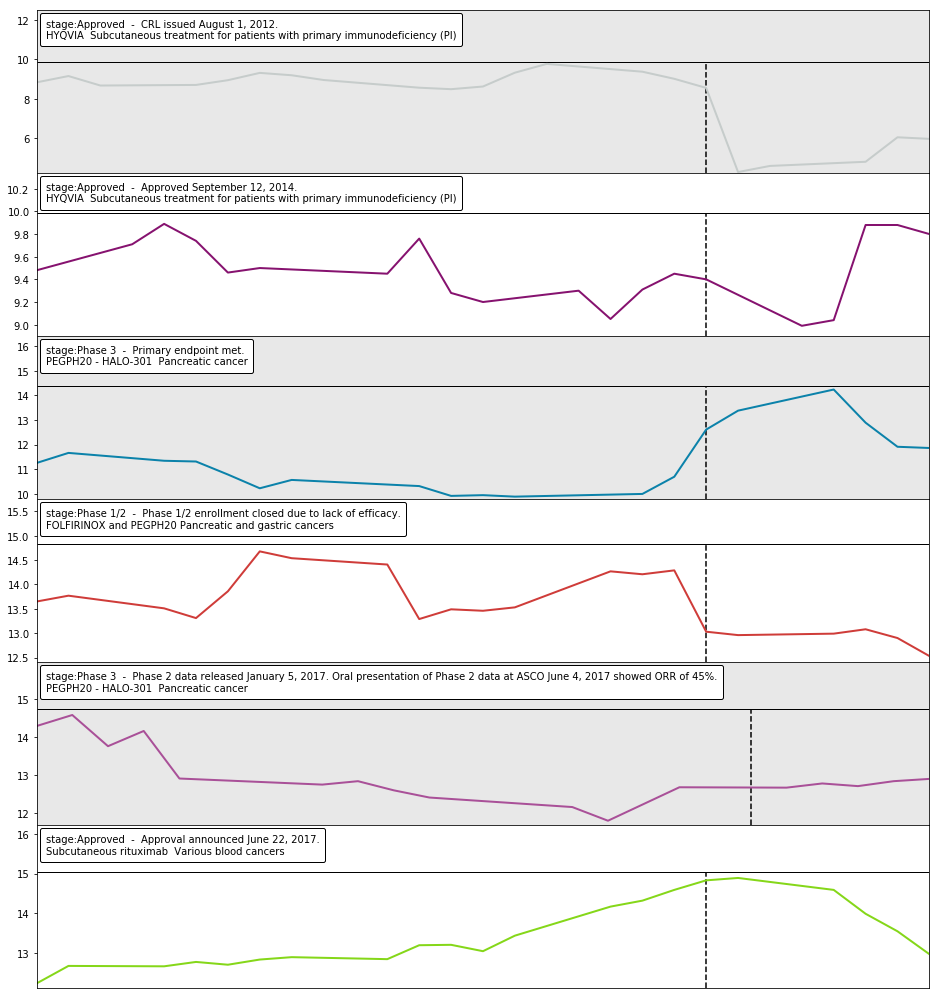

In [469]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(16,length * 3))
fig.subplots_adjust(hspace=0, wspace=0)
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage}  -{catalyst}\n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.5)
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
#     axes[count].annotate('local max', xy=(pdufa, allplots[count]["Close"].max()), xytext=(annotate, (allplots[count]["Close"].max() - allplots[count]["Close"].min()) * 0.9 + allplots[count]["Close"].min()),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),)
    # Set y limit for notes
    axes[count].set_ylim(allplots[count]["Close"].min() * .99 , (allplots[count]["Close"].max()-allplots[count]["Close"].min()) * 0.5 + allplots[count]["Close"].max())
    axes[count].hlines(allplots[count]["Close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count % 2 == 0:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  

    axes[count].vlines(pdufa, allplots[count]["Close"].min() * .99, allplots[count]["Close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["Close"],c=np.random.rand(3,), lw=2, label=pdufa) 
    axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    count = count + 1
plt.show()

In [54]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
    count = count + 1
# len(allplots[3].index) # 21
i=0
total = len(allplots[3].index) - 1

while (i < total):
    print(allplots[3].iloc[i]["Close"])
    n = i + 1
    while (n < total):  # see 14 - 8 = 1.0 !!!
        rangevalue=(allplots[3].iloc[n]["Close"] - allplots[3].iloc[i]["Close"])

        print(f"{n} - {i} = {rangevalue}")
        n=n + 1


#     print(allplots[3].iloc[i + 1]["Close"] - allplots[3].iloc[i]["Close"] )
    i = i + 1


13.65
1 - 0 = 0.11999999999999922
2 - 0 = -0.14000000000000057
3 - 0 = -0.33999999999999986
4 - 0 = 0.20999999999999908
5 - 0 = 1.0299999999999994
6 - 0 = 0.8899999999999988
7 - 0 = 0.7599999999999998
8 - 0 = -0.3600000000000012
9 - 0 = -0.16000000000000014
10 - 0 = -0.1899999999999995
11 - 0 = -0.120000000000001
12 - 0 = 0.6199999999999992
13 - 0 = 0.5600000000000005
14 - 0 = 0.6399999999999988
15 - 0 = -0.620000000000001
16 - 0 = -0.6899999999999995
17 - 0 = -0.6600000000000001
18 - 0 = -0.5700000000000003
19 - 0 = -0.75
13.77
2 - 1 = -0.2599999999999998
3 - 1 = -0.4599999999999991
4 - 1 = 0.08999999999999986
5 - 1 = 0.9100000000000001
6 - 1 = 0.7699999999999996
7 - 1 = 0.6400000000000006
8 - 1 = -0.4800000000000004
9 - 1 = -0.27999999999999936
10 - 1 = -0.3099999999999987
11 - 1 = -0.2400000000000002
12 - 1 = 0.5
13 - 1 = 0.4400000000000013
14 - 1 = 0.5199999999999996
15 - 1 = -0.7400000000000002
16 - 1 = -0.8099999999999987
17 - 1 = -0.7799999999999994
18 - 1 = -0.6899999999999995


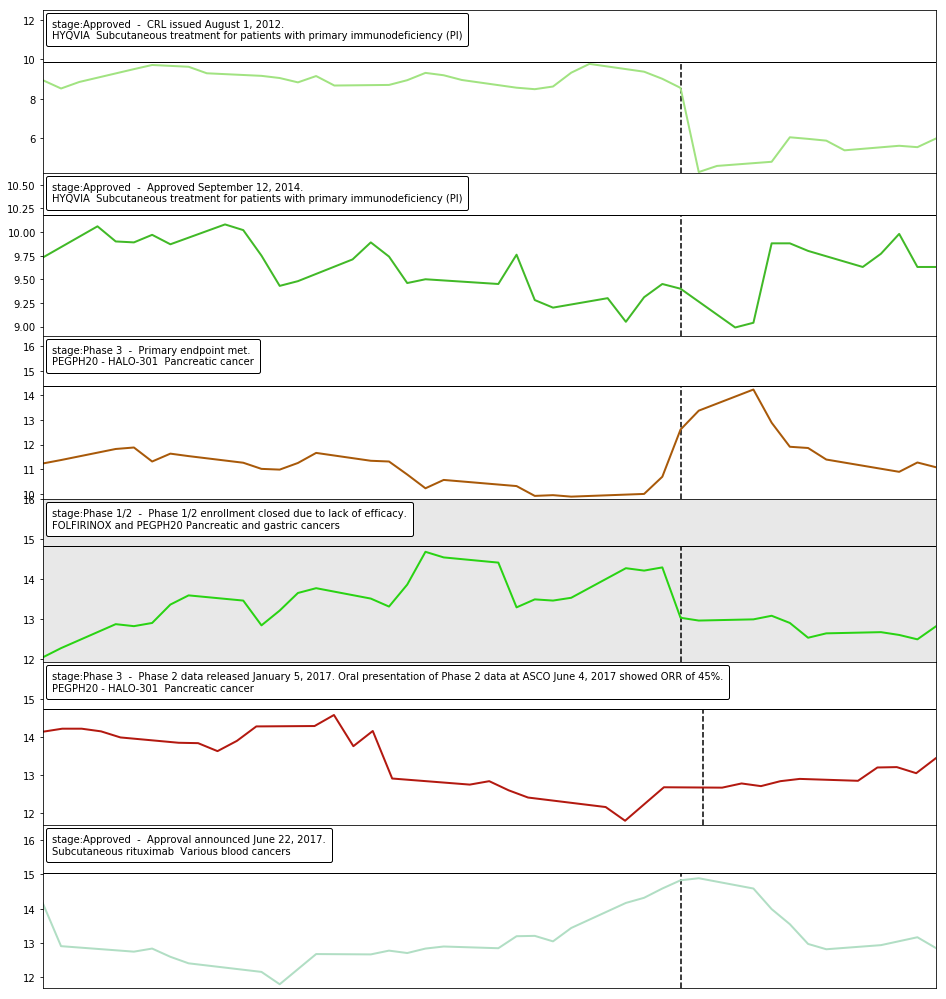

In [8]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=5)
df["Future"] = df["Date"] + DateOffset(weeks=2)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(16,length * 3))
fig.subplots_adjust(hspace=0, wspace=0)
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage}  -{catalyst}\n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.5)
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
#     axes[count].annotate('local max', xy=(pdufa, allplots[count]["Close"].max()), xytext=(annotate, (allplots[count]["Close"].max() - allplots[count]["Close"].min()) * 0.9 + allplots[count]["Close"].min()),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),)
    # Set y limit for notes
    axes[count].set_ylim(allplots[count]["Close"].min() * .99 , (allplots[count]["Close"].max()-allplots[count]["Close"].min()) * 0.5 + allplots[count]["Close"].max())
    axes[count].hlines(allplots[count]["Close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count == 3:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  

    axes[count].vlines(pdufa, allplots[count]["Close"].min() * .99, allplots[count]["Close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["Close"],c=np.random.rand(3,), lw=2, label=pdufa) 
    axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    count = count + 1
plt.show()

In [59]:
import pandas as pd
import numpy as np

data = pd.DataFrame([])

for i in np.arange(0, 4):
    if i % 2 == 0:
        data = data.append(pd.DataFrame({'A': i, 'B': i + 1}, index=[0]), ignore_index=True)
    else:
        data = data.append(pd.DataFrame({'A': i}, index=[0]), ignore_index=True)

print(data.head())


   A    B
0  0  1.0
1  1 NaN 
2  2  3.0
3  3 NaN 


C:\Users\Jason\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [20]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
    count = count + 1
# len(allplots[3].index) # 21
i=0
total = len(allplots[3].index) - 1

calcdf = pd.DataFrame([])
while (i < total):
    print(allplots[3].iloc[i]["Close"])
    n = i + 1
    while (n < total):  # see 14 - 8 = 1.0 !!!
        rangevalue=(allplots[3].iloc[n]["Close"] - allplots[3].iloc[i]["Close"])
        calcdf = calcdf.append(pd.DataFrame({count: rangevalue}, index=[0]), ignore_index=True)

        #print(f"{n} - {i} = {rangevalue}")
        n=n + 1


#     print(allplots[3].iloc[i + 1]["Close"] - allplots[3].iloc[i]["Close"] )
    i = i + 1
calcdf

13.65
13.77
13.51
13.31
13.86
14.68
14.54
14.41
13.29
13.49
13.46
13.53
14.27
14.21
14.29
13.03
12.96
12.99
13.08
12.9


6
0    0.12
1   -0.14
2   -0.34
3    0.21
4    1.03
5    0.89
6    0.76
7   -0.36
8   -0.16
9   -0.19
10  -0.12
11   0.62
12   0.56
13   0.64
14  -0.62
15  -0.69
16  -0.66
17  -0.57
18  -0.75
19  -0.26
20  -0.46
21   0.09
22   0.91
23   0.77
24   0.64
25  -0.48
26  -0.28
27  -0.31
28  -0.24
29   0.50
..    ...
160 -0.45
161 -0.63
162 -0.06
163  0.02
164 -1.24
165 -1.31
166 -1.28
167 -1.19
168 -1.37
169  0.08
170 -1.18
171 -1.25
172 -1.22
173 -1.13
174 -1.31
175 -1.26
176 -1.33
177 -1.30
178 -1.21
179 -1.39
180 -0.07
181 -0.04
182  0.05
183 -0.13
184  0.03
185  0.12
186 -0.06
187  0.09
188 -0.09
189 -0.18

[190 rows x 1 columns]

In [68]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=5)
df["Future"] = df["Date"] + DateOffset(weeks=2)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
allplots=[]
e = []
# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    d = []
    #Annotation
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
    i=0
#     print(len(allplots[count].index))
    total = len(allplots[count].index) - 1
    while (i < total):
        n = i + 1
        while (n < total):  # see 14 - 8 = 1.0 !!!
            rangevalue=(allplots[count].iloc[n]["Close"] - allplots[count].iloc[i]["Close"])
            d.append(rangevalue)
            range = f"{n} - {i}"
            print(d)
            n=n + 1
        i = i + 1
    e.append(d)
    count = count + 1
#need to add row names to see what the ranges are specifically.
finaldf=pd.DataFrame(e).transpose()
# finaldf
# plt.pcolor(finaldf)


[-0.41999999999999993]
[-0.41999999999999993, -0.08999999999999986]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005, 0.7700000000000014]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005, 0.7700000000000014, 0.6800000000000015]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005, 0.7700000000000014, 0.6800000000000015, 0.3500000000000014]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005, 0.7700000000000014, 0.6800000000000015, 0.3500000000000014, 0.22000000000000064]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005, 0.7700000000000014, 0.6800000000000015, 0.3500000000000014, 0.22000000000000064, 0.11000000000000121]
[-0.41999999999999993, -0.08999999999999986, 0.5600000000000005, 0.7700000000000014, 0.6800000000000015, 0.3500000000000014, 0.22000000000000064, 0.11000000000000121, -0.10999999999999943]
[-0.41999999999999993, -0.08999999999999986, 0.560

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-1.25]
[-1.25, -1.370000000000001]
[-1.25, -1.370000000000001, -1.4100000000000001]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75, -2.0]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75, -2.0, -2.3599999999999994]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75, -2.0, -2.3599999999999994, -1.92]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75, -2.0, -2.3599999999999994, -1.92, -1.4800000000000004]
[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75, -2.0, -2.3599999999999994, -1.92, -1.4800000

[-1.25, -1.370000000000001, -1.4100000000000001, -1.3200000000000003, -1.5600000000000005, -1.75, -2.0, -2.3599999999999994, -1.92, -1.4800000000000004, -1.4900000000000002, -1.3800000000000008, -1.4499999999999993, -1.3200000000000003, -1.2599999999999998, -1.3100000000000005, -0.9600000000000009, -0.9499999999999993, -1.1099999999999994, -0.7200000000000006, 0.009999999999999787, 0.16000000000000014, 0.4299999999999997, 0.6699999999999999, 0.7300000000000004, 0.4299999999999997, -0.16999999999999993, -0.6099999999999994, -1.1850000000000005, -1.3399999999999999, -1.2200000000000006, -0.9900000000000002, -0.120000000000001, -0.16000000000000014, -0.07000000000000028, -0.3100000000000005, -0.5, -0.75, -1.1099999999999994, -0.6699999999999999, -0.23000000000000043, -0.2400000000000002, -0.13000000000000078, -0.1999999999999993, -0.07000000000000028, -0.009999999999999787, -0.0600000000000005, 0.28999999999999915, 0.3000000000000007, 0.14000000000000057, 0.5299999999999994, 1.25999999999

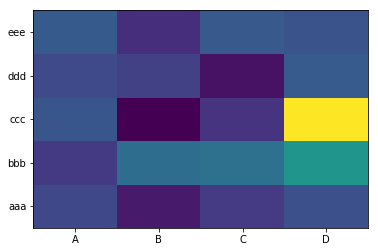

In [36]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
Cols = ['A', 'B', 'C', 'D']
df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [59]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=5)
df["Future"] = df["Date"] + DateOffset(weeks=2)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
allplots=[]
e = []
# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    d = []
    #Annotation
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
    i=0
    print(len(allplots[count].index))
    total = len(allplots[count].index)
    i = 1
    while (i < total):
        rangevalue=(allplots[count].iloc[i]["Close"] - allplots[count].iloc[i - 1]["Close"])
        d.append(rangevalue)
        i = i + 1
    e.append(d)
    count = count + 1
#need to add row names to see what the ranges are specifically.
finaldf=pd.DataFrame(e).transpose()
# finaldf
# # pd.DataFrame(allplots[0]["Close"]).diff()
pd.DataFrame(allplots["Close"])

35
35
33
36
34
34


TypeError: list indices must be integers or slices, not str

In [2]:
from pandas.tseries.offsets import BDay
import pandas as pd
idx = [pd.to_datetime('20181220'), pd.to_datetime('20181221'), 
       pd.to_datetime('20181222'), pd.to_datetime('20181223'), 
       pd.to_datetime('20181224'), pd.to_datetime('20181224'), 
       pd.to_datetime('20181226'), pd.to_datetime('20181227')]
df = pd.DataFrame(0, index=idx, columns=['A'])
df.index = df.index.map(lambda x : x + 0*BDay())
df

A
2015-04-30  0
2015-06-01  0
2015-06-30  0